In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt
import antropy as ant
from nolds import sampen
import spkit as sp
import seaborn as sns
sns.set()
import EntropyHub as En
from sklearn.preprocessing import MinMaxScaler
import warnings
from vmdpy import VMD
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
EEG_78_CH2 = pd.read_csv('EEG_78_CH2.csv')
bis_78 = pd.read_csv('bis_78.csv')
B78=bis_78['BIS/BIS']
E78=EEG_78_CH2['BIS/EEG2_WAV']
print ('The shape of EEG signals and BIS for patient 78 is {} and {} '.format(E78.shape,B78.shape) )
print ('The type of EEG signals and BIS for patient 78 is {} and {} '.format(type(E78),type(B78)) )

The shape of EEG signals and BIS for patient 78 is (535191,) and (4180,) 
The type of EEG signals and BIS for patient 78 is <class 'pandas.core.series.Series'> and <class 'pandas.core.series.Series'> 


In [3]:
#checking for missing values

def missing_values(eeg_signal):

    # Check for missing values
    missing_values = np.isnan(eeg_signal)
    length_signals = len(eeg_signal)

    # Count the number of missing values
    num_missing_values = np.sum(missing_values)
    percentage_missing_values = (num_missing_values/length_signals)*100

    # Print the indices and values of missing values
    missing_indices = np.where(missing_values)[0]
    missing_values_list = eeg_signal[missing_indices]

    print("Missing Values:")
    print(f"Total Missing Values: {num_missing_values}")
    print(f"Percentage of Missing Values: {percentage_missing_values} %")  
missing_values(E78)

Missing Values:
Total Missing Values: 167
Percentage of Missing Values: 0.03120381321808476 %


In [4]:
E78_copy = np.copy(E78)

In [5]:
# Handling missing values

def handle_missing_values(signal):
    # Interpolate missing values using linear interpolation
    mask = np.isnan(signal)
    signal[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), signal[~mask])
    return signal
E78_copy=handle_missing_values(E78_copy)

In [13]:
# Assuming BIS and EEG are numpy arrays
BIS = B78
EEG = E78_copy

# Define the sampling frequency
fs = 128

# Define the indices for BIS range from 200 to 800
bis_start_index =27
bis_end_index = 4000

# Convert the BIS indices to EEG indices

eeg_start_index = bis_start_index * fs
eeg_end_index = bis_end_index * fs

# Select EEG values for BIS[200:800]
selected_EEG = EEG[eeg_start_index:eeg_end_index]
selected_bis = BIS[bis_start_index:bis_end_index]
selected_bis = np.array(selected_bis)
print(selected_EEG)


[-12.7  -12.55 -15.   ...  -5.85  -5.5   -5.65]


Number of BIS before windowing: 3973


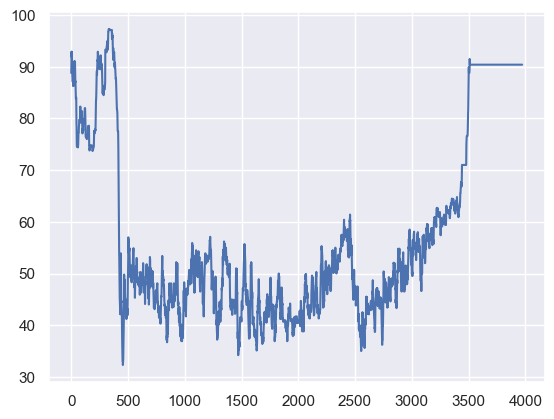

In [14]:
# Replacing the zero values in BIS
from scipy.interpolate import interp1d

def replace_zeroes_with_interpolation(series):
    # Find indices and values of non-zero elements
    non_zero_indices = [i for i, val in enumerate(series) if val != 0]
    non_zero_values = [series[i] for i in non_zero_indices]

    # Create an interpolation function using scipy's interp1d
    interpolation_function = interp1d(non_zero_indices, non_zero_values, kind='linear', bounds_error=False, fill_value="extrapolate")

    # Replace zeroes with interpolated values
    new_series = [interpolation_function(i) if val == 0 else val for i, val in enumerate(series)]

    return new_series

# Test the function
series = selected_bis
new_bis = replace_zeroes_with_interpolation(series)
plt.plot(new_bis)
print("Number of BIS before windowing:", len(new_bis))

In [15]:
# Define the EEG signal
eeg_signal = selected_EEG # Replace with your actual EEG signal


# Define the filter function
def bandpass_filter(signal, lowcut, highcut, fs, order=3):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# time in seconds
time = np.arange(len(eeg_signal)) / fs

# Apply bandpass filters to the EEG signal
bpass = bandpass_filter(eeg_signal, 0.01, 63.5, fs=128)

In [24]:
# For EEG

def moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate):
    # Convert window size and overlap from seconds to samples
    window_size = int(window_size_sec * sampling_rate)
    overlap = int(overlap_sec * sampling_rate)

    # Calculate the stride based on the window size and overlap
    stride = window_size - overlap

    # Determine the total number of windows
    num_windows = (len(data) - window_size) // stride + 1

    # Initialize variables
    windows = []

    # Loop over the windows
    for i in range(num_windows):
        window_start = i * stride
        window_end = window_start + window_size
        window = data[window_start:window_end][0]
        windows.append(window)

    return windows

# Example usage
data = bpass  # Sample data
window_size_sec = 56.0       # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second

# Apply moving sliding window
eeg_windows = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate)

# Print the number of windows and the shape of the first window
print("Number of BIS:", len(eeg_windows))
#plt.plot(bis_windows)
#plt.show()


Number of BIS: 3918


In [29]:
def moving(data, method):
    alpha = 2000
    tau = 0.5
    K = 5
    DC = 0
    init = 1           # initialize omegas uniformly  
    tol = 1e-7 

    # Run VMD on the signal
    modes, spectrum, omega =VMD (data, alpha, tau, K, DC, init,tol)
    
    result=[]
    
    if method == "sample entropy":
            # Calculate sample entropy within the window
            embedding_dimension = 2
            tolerance = 0.2
            sample_entropy[0] = sampen(modes[0], emb_dim=embedding_dimension, tolerance=tolerance)
            sample_entropy[1]= sampen(modes[1], emb_dim=embedding_dimension, tolerance=tolerance)
            sample_entropy[2]= sampen(modes[2], emb_dim=embedding_dimension, tolerance=tolerance)
            sample_entropy[3] = sampen(modes[3], emb_dim=embedding_dimension, tolerance=tolerance)
            sample_entropy[4] = sampen(modes[4], emb_dim=embedding_dimension, tolerance=tolerance)
            result.append(sample_entropy[0],sample_entropy[1],sample_entropy[2],sample_entropy[3],sample_entropy[4])
            
    return result


moving(eeg_windows, method="sample_entropy")

[]

In [ ]:
def moving(data, method):
    alpha = 2000
    tau = 0.5
    K = 5
    DC = 0
    init = 1           # initialize omegas uniformly  
    tol = 1e-7 

    # Run VMD on the signal
    modes, spectrum, omega =VMD (data, alpha, tau, K, DC, init,tol)
    
    result=[]
    
    if method == "sample entropy":
            # Calculate sample entropy within the window
    
            sample_entropy[0] = ant.perm_entropy(modes[1])
            sample_entropy[1]= ant.perm_entropy(modes[1])
            sample_entropy[2]= sampen(modes[2], emb_dim=embedding_dimension, tolerance=tolerance)
            sample_entropy[3] = sampen(modes[3], emb_dim=embedding_dimension, tolerance=tolerance)
            sample_entropy[4] = sampen(modes[4], emb_dim=embedding_dimension, tolerance=tolerance)
            result.append(sample_entropy[0],sample_entropy[1],sample_entropy[2],sample_entropy[3],sample_entropy[4])
            
    return result


moving(eeg_windows, method="sample_entropy")

In [34]:
y = ant.perm_entropy(modes[1])
y

1.7306810274554913

In [17]:
def VMD (signal, alpha, tau, K, DC, init,tol)
# Set VMD parameters
alpha = 2000
tau = 0.5
K = 5
DC = 0
init = 1           # initialize omegas uniformly  
tol = 1e-7 

# Run VMD on the signal
modes, spectrum, omega =VMD (signal, alpha, tau, K, DC, init,tol)

SyntaxError: invalid syntax (498820023.py, line 1)

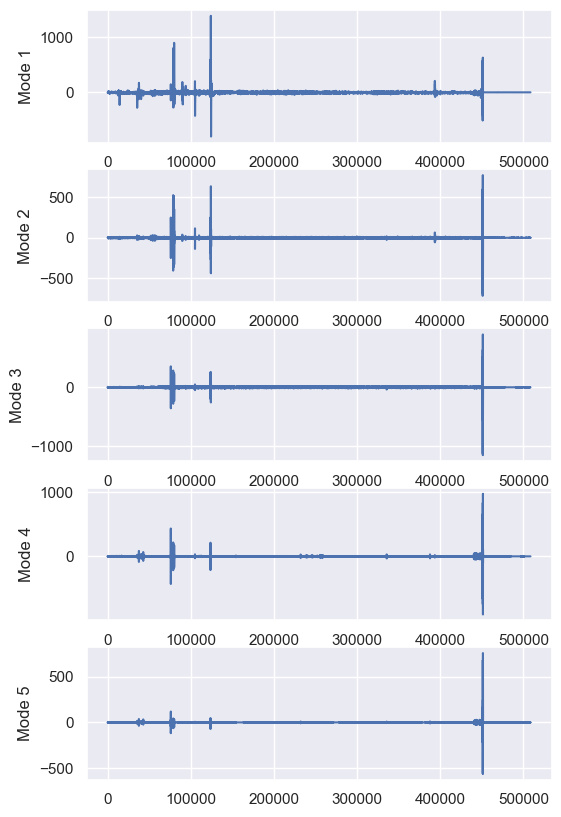

In [18]:
signal = selected_EEG

# Set VMD parameters


#Plot the decomposed modes
import matplotlib.pyplot as plt
fig, axs = plt.subplots(K, 1, figsize=(6, 10))
for i in range(K):
    axs[i].plot(modes[i, :])
    axs[i].set_ylabel(f"Mode {i+1}")
plt.show()

In [19]:
def moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method):
    # Convert window size and overlap from seconds to samples
    window_size = int(window_size_sec * sampling_rate)
    overlap = int(overlap_sec * sampling_rate)

    # Calculate the stride based on the window size and overlap
    stride = window_size - overlap

    # Determine the total number of windows
    num_windows = (len(data) - window_size) // stride + 1

    # Initialize variables
    
    result = []
    
    # Loop over the windows
    for i in range(num_windows):
        window_start = i * stride
        window_end = window_start + window_size
        window = data[window_start:window_end]
        
        if method == "sample entropy":
            # Calculate sample entropy within the window
            embedding_dimension = 2
            tolerance = 0.2
            sample_entropy = sampen(window, emb_dim=embedding_dimension, tolerance=tolerance)
            result.append(sample_entropy)
    return result

In [20]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128 


resultsa_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='sample entropy')
resultsa_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='sample entropy')
resultsa_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='sample entropy')
resultsa_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='sample entropy')
resultsa_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='sample entropy')
print(f"Number of features:", len(resultsa_0))

KeyboardInterrupt: 

In [ ]:
# # Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultsa_0)
axes[0, 0].set_title('lzc_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultsa_1)
axes[0, 1].set_title('lzc_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultsa_2)
axes[0, 2].set_title('lzc_mode 2')

axes[1, 0].plot(resultsa_3)
axes[1, 0].set_title('lzc_mode 3')

axes[1, 1].plot(resultsa_4)
axes[1, 1].set_title('lzc_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()

# Display the figure
plt.show()